# Treelets Python Implementation

Python implementation of the treelets algorithm to cement my understanding. Working functions will be wrapped in a module and used to compare the treelets decomposition to PCA. 

## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import sys
import numpy as np
import pandas as pd
import os

In [2]:
sys.path.append("../scripts")
import python_treelet_implementation as pytree
import utils

## Workings

Example of the implementation applied to noise. Note that both original paper and CRAN implementation use the correlation between two variables a measure of their similarity. The parameter `abs_` controls whether the correlation or absolute correlation is used as a similarity measure. 

In [3]:
test_data = np.array([np.random.normal(0,1,400)])\
              .reshape(4,100)
np.cov(test_data)

array([[ 1.11996749, -0.0049467 ,  0.02016802, -0.03977121],
       [-0.0049467 ,  0.80630094, -0.11024537,  0.20480118],
       [ 0.02016802, -0.11024537,  0.96404256,  0.04159646],
       [-0.03977121,  0.20480118,  0.04159646,  1.22730231]])

Build treelet decomposition.  

In [4]:
tree = pytree.treelet_decomposition(X = test_data, 
                                    L = 4)

### Treelet covariance matrix

At each level we can extract the treelet variance-covaraince matrix.  

In [6]:
tree[2]["C"]

array([[ 1.12253387e+00, -4.56826350e-03, -1.28433778e-17,
        -3.87718293e-02],
       [-4.56826350e-03,  7.23111204e-01, -1.18163290e-01,
         2.68188421e-17],
       [ 1.73069322e-17, -1.18163290e-01,  9.61476179e-01,
         1.95913062e-03],
       [-3.87718293e-02, -3.41647276e-17,  1.95913062e-03,
         1.31049204e+00]])

### Orderings

We can extract which variables were merged at each level, and which was designated the sum variable. 

In [7]:
tree[2]["pair"]

(0, 2)

In [8]:
tree[2]["order"]

(1, 0)

### Dirac basis 

At each level we can extract the Dirac basis. 

In [9]:
tree[2]["B"]

array([[ 0.99200074,  0.        , -0.12623209,  0.        ],
       [ 0.        ,  0.92648353,  0.        ,  0.37633532],
       [ 0.12623209,  0.        ,  0.99200074,  0.        ],
       [ 0.        , -0.37633532,  0.        ,  0.92648353]])

## Comparison with CRAN test data

Python implementation applied to similarity matrix supplied with the package. Prior to applying the treelet transform no block structure is apparent.

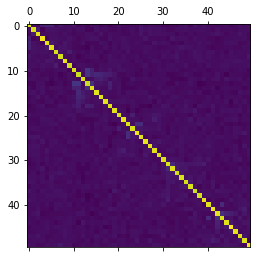

In [10]:
Ahat = pd.read_csv("../data/Ahat.csv")\
         .drop("Unnamed: 0", axis = 1)\
         .to_numpy()
plt.matshow(Ahat)

The implementation achieves the same treelet covaraince matrix (up to rounding errors) and varaible merges in the same order as code on CRAN. Even at low levels of the tree the block structure is apparent. Using the absolute value of the correlation matrix lead to variable merges being performed a different order, and a different treelet decomposition. At low levels a block structure is still visible. 

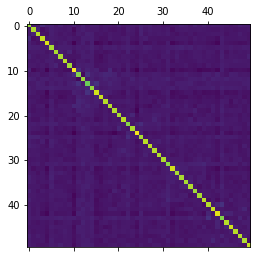

In [11]:
tree = pytree.treelet_decomposition(X = Ahat,
                                    L = 50)
plt.matshow(tree[10]["C"])

## Comparison with Theory on Block Covaraince Matrices

### Test with Lemma 1

At each level $l$ the population treelet decomposition on single-block covaraince matrix returns sum varaible $s_{l,i}$ which is defined on a disjoint set $\mathcal{A}_{l,i} \subseteq \left \{ 1,...,p \right \}$ and a scaling function $\phi_{l,i}$ with non-zero entries only for elements in $\mathcal{A}_{l,i}$, in particular: 

* sum variable: $s_{l,i} = \frac{1}{\sqrt{\mathcal{A}_{l,i}}} \sum_{j \in \mathcal{A}_{l,i}} x_j$
* scaling function: $\phi_{l,i} = \frac{1}{\sqrt{\mathcal{A}_{l,i}}}\times \mathcal{I}_{s_{l,i}}$

The following example with a $5 \times 5$ matrix of ones shows this to be true. At the population level additive noised corresponds to adding the noise variance to the diagonal of the correlation matrix. 

In [118]:
tree = pytree.treelet_decomposition(X = np.ones((5,5)) + .2*np.eye(5),
                                    L = 5)

In [119]:
tree[4]["B"]

array([[ 0.4472136 , -0.70710678, -0.40824829, -0.28867513, -0.2236068 ],
       [ 0.4472136 ,  0.70710678, -0.40824829, -0.28867513, -0.2236068 ],
       [ 0.4472136 ,  0.        ,  0.81649658, -0.28867513, -0.2236068 ],
       [ 0.4472136 ,  0.        ,  0.        ,  0.8660254 , -0.2236068 ],
       [ 0.4472136 ,  0.        ,  0.        ,  0.        ,  0.89442719]])

### Tests with Theorem 2

The population treelet decomposition on a standard block covariance matrix having $k$ blocks with low "between block" covariance and high "within block" covaraince returns sum variables and scaling functions which are constant on each block $\mathcal{B}_k$, in particuar: 

* sum variable: $s_k = \frac{1}{\sqrt{p_k}}\sum_{j \in \mathcal{B}_k} x_k$
* scaling function: $\phi_{k} = \frac{1}{\sqrt{p_k}}\times\mathcal{I}_{\mathcal{B}_k}$

The following example with a block diagonal matrix shows this to be true. 

In [120]:
A = B = C = np.ones((2,2))
tree = pytree.treelet_decomposition(X = block_diag(A,B,C) + .2*np.eye(6),
                                    L = 6
                                   )

In [121]:
tree[3]["B"]

array([[ 0.70710678, -0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.70710678,  0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.70710678, -0.70710678,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.70710678,
        -0.70710678],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.70710678,
         0.70710678]])